## Table of contents :
* [I - Build dataset](#first)
    * [1 - Merge Stack Exchange Data Explorer extracts](#first_1)
    * [2 - Data-cleaning](#first_2)
* [II - EDA](#second)
    * [1 - Univariate analysis](#second_1)
        * [1.1 - Overview](#second_1_1)
        * [1.2 - Distributions of quantitative variables](#second_1_2)
        * [1.3 - Feature engineering](#second_1_3)
        * [1.4 - _n_ most frequent tags](#second_1_4)
        * [1.5 - Filter tags](#second_1_5)
    * [2 - Multivariate analysis](#second_2) 
    * [3 - Factorial analysis (PCA)](#second_3) 
    
* [III - Text mining](#third)
    * [1 - Preprocessing (tokenize & normalize text data)](#third_1)
    * [2 - Export modelization dataset](#third_2)
    * [3 - Areas for improvement ](#third_3)

In [1]:
import sys
sys.path.append("..")
# Personal package named src
from src.datacleaner import *
# Data preprocessing
from src.preprocessor import *
# EDA
from src.analyzer.univariate import *
from src.analyzer.multivariate import *
from src.nlp.text_preprocessor import *
# Dimensionality reduction
from src.dimensionality_reducer.pca import LinearPCA
from src.dimensionality_reducer.tsne import tSNE
sns.set()
%matplotlib inline

# I - Build dataset <a class="anchor" id="first"></a>

## 1 - Merge Stack Exchange Data Explorer extracts <a class="anchor" id="first_1"></a>

In [2]:
# Concat SO extracts

# 4 274 696 questions asked in 2019
raw_df = concat_samples(sample_path='../data/csv/data_2019/',
                        sample_frac=None,
                        n_first_samples=None,
                        n_last_samples=None)
print(raw_df.shape)
# Build working dataset
df = raw_df.copy()
df.head(1)

(346570, 11)


,Id,Score,AnswerCount,CreationDate,Title,Body,Tags,AnswerId,AnswerScore,AnswerCreationDate,Answer
0,59121370,1,1,2019-11-30 23:55:22,CPS Coroutines: Why does this example require ...,"<p>I am trying to figure out <a href=""https://...",<haskell><monads><coroutine><continuations>,59121850,2,2019-12-01 01:40:01,<p>It doesn't look to me like it works. The ex...


## 2 - Data-cleaning <a class="anchor" id="first_2"></a>

In [3]:
# Drop duplicates rows
df.drop_duplicates(inplace=True)
print(df.shape)

(346570, 11)


In [4]:
# Drop duplicate questions
df.drop_duplicates(subset='Title', inplace=True)
df.drop_duplicates(subset='Body', inplace=True)
df.shape

(346567, 11)

In [5]:
# Display NaN count for each column
nan_count(df, margin_size=98)

Id------------------------------------------------------------------------------------------------ 0  (0.0%)
Score--------------------------------------------------------------------------------------------- 0  (0.0%)
AnswerCount--------------------------------------------------------------------------------------- 0  (0.0%)
CreationDate-------------------------------------------------------------------------------------- 0  (0.0%)
Title--------------------------------------------------------------------------------------------- 0  (0.0%)
Body---------------------------------------------------------------------------------------------- 0  (0.0%)
Tags---------------------------------------------------------------------------------------------- 0  (0.0%)
AnswerId------------------------------------------------------------------------------------------ 0  (0.0%)
AnswerScore--------------------------------------------------------------------------------------- 0  (0.0%)
AnswerCreationDate-

# II - EDA <a class="anchor" id="second"></a>

## 1 - Univariate analysis <a class="anchor" id="second_1"></a>

### 1.1 - Overview <a class="anchor" id="second_1_1"></a>

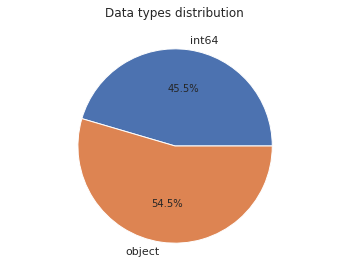

In [6]:
# Plot data types distributions
plot_empirical_distribution(df.dtypes, var_type='quali', title='Data types')

In [7]:
# Quantitative variables overview
numerical_cols = [col for col in df.select_dtypes(include=[float, int]).columns if 'Id' not in col]
print(f'Total numerical columns : {df[numerical_cols].shape[1]}')
df[numerical_cols].head(2)

Total numerical columns : 3


,Score,AnswerCount,AnswerScore
0,1,1,2
1,2,1,2


In [8]:
# Qualitative variables overview
categorical_cols = df.select_dtypes(include=[object]).columns
print(f'Total categorical columns : {df[categorical_cols].shape[1]}')
df[categorical_cols].head(2)

Total categorical columns : 6


,CreationDate,Title,Body,Tags,AnswerCreationDate,Answer
0,2019-11-30 23:55:22,CPS Coroutines: Why does this example require ...,"<p>I am trying to figure out <a href=""https://...",<haskell><monads><coroutine><continuations>,2019-12-01 01:40:01,<p>It doesn't look to me like it works. The ex...
1,2019-11-30 23:52:11,In Blazor client app after login top of home p...,<p>After every login in a Blazor client app I ...,<.net-core><blazor>,2019-12-01 10:42:23,<p>There is a small problem in the code of tha...


### 1.2 - Distributions of quantitative variables <a class="anchor" id="second_1_2"></a>

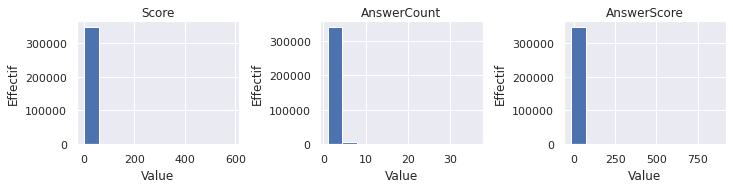

In [9]:
plot_hist_subplots(df, numerical_cols, shape=(2, 4), fig_size=(16, 6))

In [10]:
pd.concat([measures_table(df, col).T.iloc[:, 1:] for col in numerical_cols]).astype(int)

,mean,std,min,25%,50%,75%,max
Score,2,4,1,1,1,2,585
AnswerCount,1,0,1,1,1,2,36
AnswerScore,2,6,-17,1,2,3,878


In [11]:
# Filter questions with a low score (lower than mean score) and no answers
# See : https://meta.stackoverflow.com/questions/364231/what-is-the-difference-between-reputation-and-score
# df = df[(df['Score'] > 1) & (df['AnswerScore'] > 1)]
# get_data_loss(df, raw_df)

### 1.3 - Feature engineering <a class="anchor" id="second_1_3"></a>

#### Question length

In [11]:
# Get text columns
text_columns = ['Title', 'Body', 'Answer']

for text_col in text_columns:
    # Remove HTML tags
    df[text_col] = df[text_col].map(lambda question: filter_html_tags(question))
    # Get text column length
    df[f'{text_col}Length'] =  df[text_col].map(len)
    
# Get question length    
df['QuestionLength'] = df['TitleLength'] + df['BodyLength']

In [12]:
# Get relevant quantitative variables (update from feature engineering)
numerical_cols = [col for col in df.select_dtypes(include=[float, int]).columns if 'Id' not in col]
print(f'Total numerical columns : {df[numerical_cols].shape[1]}')

Total numerical columns : 7


In [13]:
pd.concat([measures_table(df, col).T.iloc[:, 1:] for col in numerical_cols]).astype(int)

,mean,std,min,25%,50%,75%,max
Score,2,4,1,1,1,2,585
AnswerCount,1,0,1,1,1,2,36
AnswerScore,2,6,-17,1,2,3,878
TitleLength,59,21,1,44,56,70,150
BodyLength,1511,1893,33,587,1002,1728,32557
AnswerLength,988,1244,27,354,646,1170,30480
QuestionLength,1570,1895,55,644,1061,1789,32598


In [15]:
# df[df['AnswerScore'] < 1]

In [14]:
# Filter questions with a negative answer score
previous_rows_count = df.shape[0]
df = df[df['AnswerScore'] > 0]
get_data_loss(df, previous_rows_count)

Dataframe rows reduced by 16.7 % (346567 -> 288808)


In [15]:
quanti_var_desc_df = pd.concat([measures_table(df, col).T.iloc[:, 1:] for col in numerical_cols]).astype(int)
quanti_var_desc_df

,mean,std,min,25%,50%,75%,max
Score,2,5,1,1,1,2,585
AnswerCount,1,1,1,1,1,2,36
AnswerScore,3,7,1,1,2,3,878
TitleLength,58,21,4,44,56,70,150
BodyLength,1465,1842,33,573,975,1675,32557
AnswerLength,1004,1259,27,363,659,1189,30480
QuestionLength,1524,1844,71,630,1034,1736,32598


In [16]:
quanti_var_desc_df.loc['QuestionLength']['mean'] / quanti_var_desc_df.loc['AnswerLength']['mean']
# The questions are on average 50% longer than the answers

1.5179282868525896

In [17]:
quanti_var_desc_df.loc['QuestionLength']['50%'] / quanti_var_desc_df.loc['AnswerLength']['50%']
# The questions are on median 50% longer than the answers

1.5690440060698028

In [18]:
quanti_var_desc_df.loc['TitleLength']['mean'] / quanti_var_desc_df.loc['QuestionLength']['mean']
# The question title lengths are on average around 4% of the total question lengths

0.03805774278215223

#### Tags

In [19]:
# Translator table (characters to delete)
tags_translator = {'><': ' ', '>': '', '<': ''}
# Clean tags feature by removing irrelevant characters & decompose string as list of tags
df['Tags'] = df['Tags'].map(lambda tags: replace_characters(tags, tags_translator).split(' '))
# Get tags count
df['TotalTags'] = df['Tags'].map(len)
# Get unique tags
unique_tags = list(set([tag for tags in df.Tags.values for tag in tags]))
# Tag counts
print('{} unique tags (total tags = {})'.format(read_int_cleaner(len(unique_tags)),
                                                read_int_cleaner(df['TotalTags'].sum())))

25 039 unique tags (total tags = 862 023)


In [20]:
df['TotalTags'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
TotalTags,288808.0,2.984762,1.212269,1.0,2.0,3.0,4.0,6.0


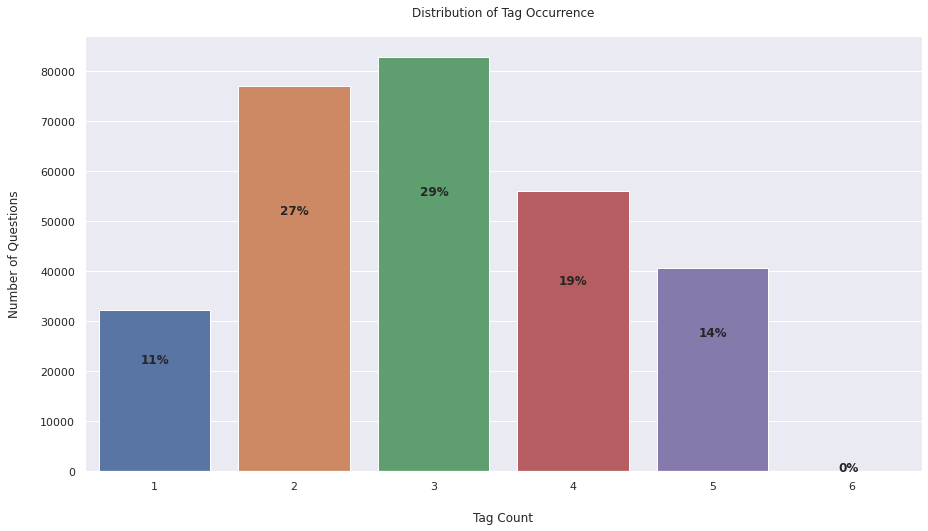

In [21]:
# Number of tags by question
count_plot(df,
           'TotalTags',
           xlabel='Tag Count',
           ylabel='Number of Questions',
           title='Distribution of Tag Occurrence',
           bar_type='v',
           precision=0)
# 88.8 % of questions have more than 1 tag

In [22]:
# Filter number of tags by question outlier
previous_rows_count = df.shape[0]
df = df[df['TotalTags'] < 6]
get_data_loss(df, previous_rows_count, precision=3)

Dataframe rows reduced by 0.001 % (288808 -> 288806)


Text(0.5, 1.05, '5 Most Common Tags For Each Tag Occurrence By Question')

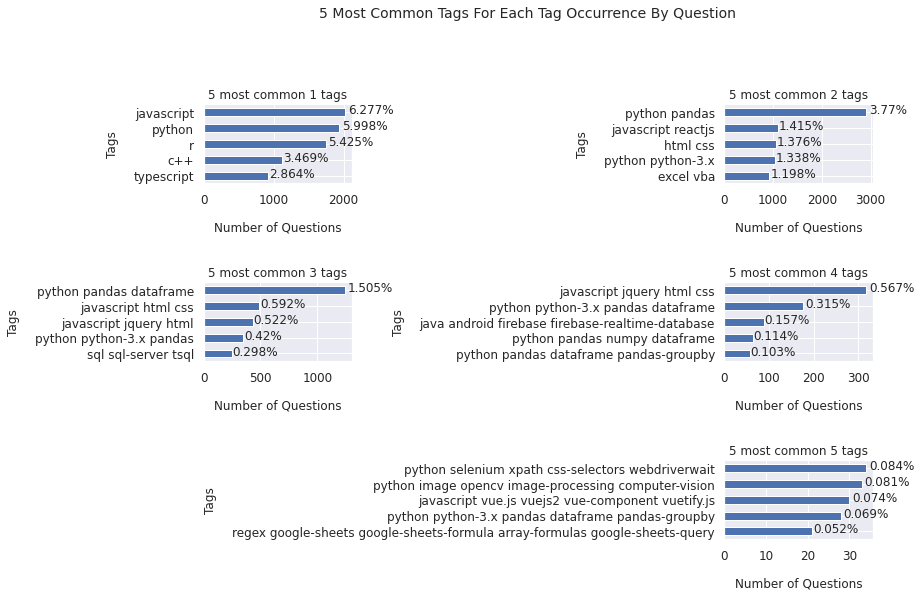

In [23]:
# 5 most common tags for each number of tags by question

unique_tags_nb = sorted(df['TotalTags'].unique().tolist())

tags_nb_data = [[' '.join(x) for x in df[df['TotalTags'] == n]['Tags']] for n in unique_tags_nb]

tags_nb_fig, axes = plt.subplots(3, 2, figsize=(20, 24))
tags_nb_fig.delaxes(axes[2, 1])
tags_nb_fig.subplots_adjust(hspace=1.25, wspace=2.5)
axes = [a for r in axes for a in r]
for a, data in zip(axes, tags_nb_data):
    if len(data[0].split(' ')) == 5:
        a = plt.subplot2grid((3, 2), (2, 1), colspan=5)
        tags_nb_fig.axes[4].remove() 
    plot_n_frequent_tokens(tokens=data,
                           n=5,
                           #plot_size=(10, 6),
                           plot_type='barh',
                           token_type='{} tag'.format(len(data[0].split(' '))),
                           precision=3,
                           subplot_axis=a)
    a.set_xlabel('Number of Questions', labelpad=15)
    a.set_ylabel('Tags', labelpad=15)
    
tags_nb_fig.suptitle('5 Most Common Tags For Each Tag Occurrence By Question', fontsize=14, y=1.05)

#tags_nb_fig.tight_layout()

### 1.4 - _n_ most frequent tags  <a class="anchor" id="second_1_4"></a>

Total unique tags : 25039


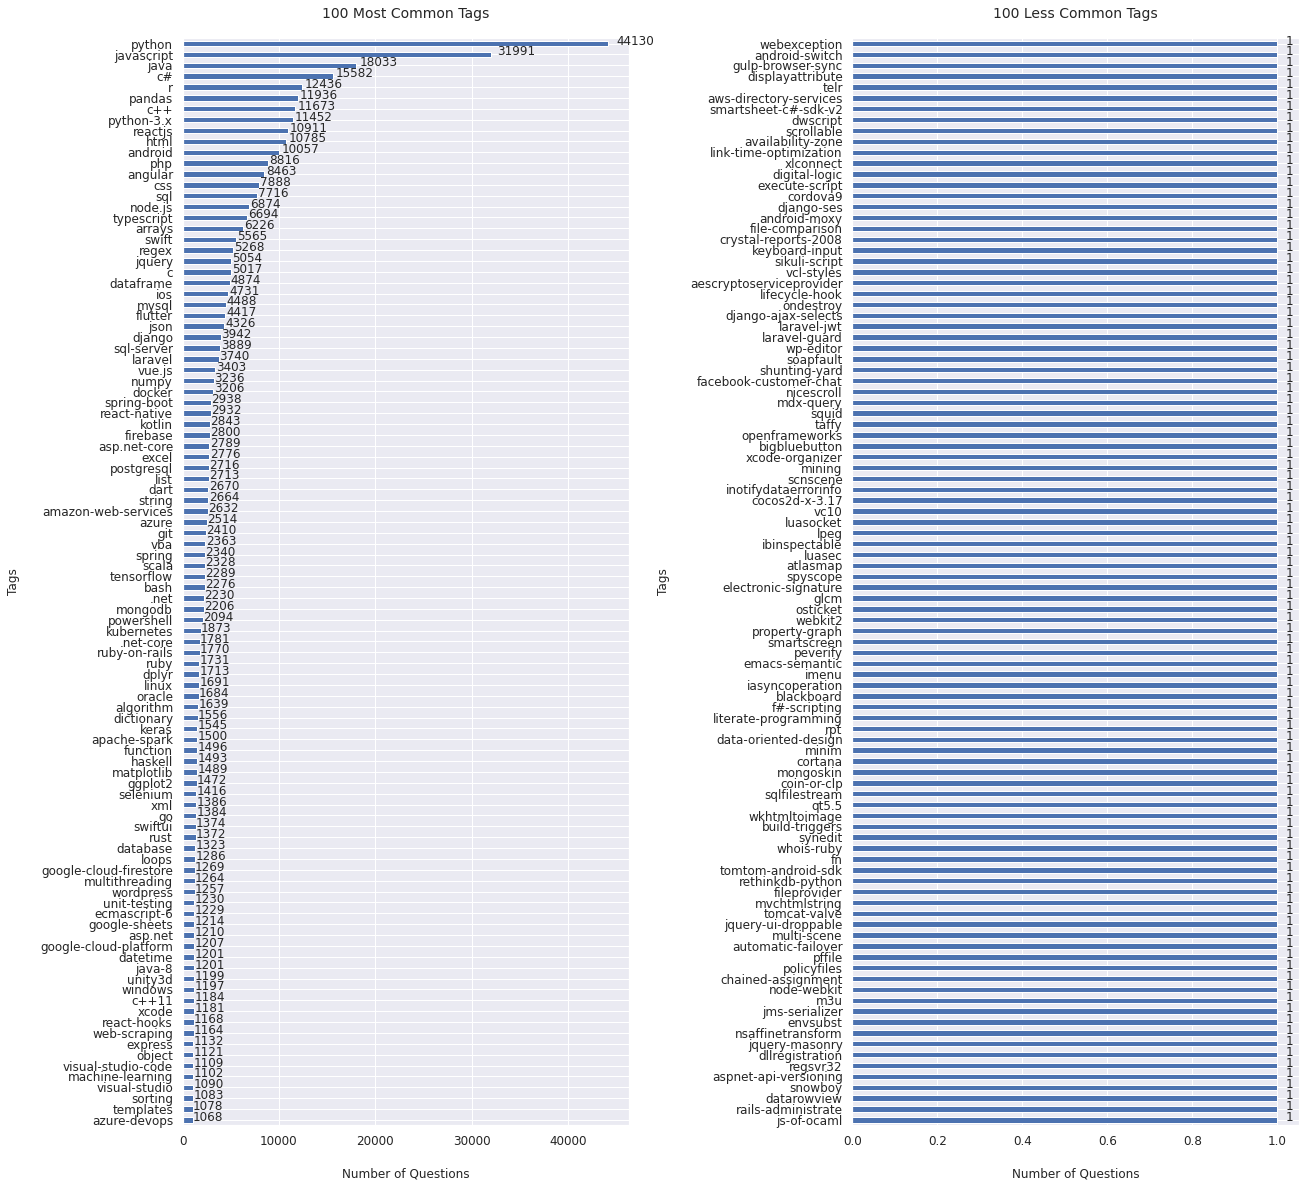

In [24]:
# Get all tags from dataset
tags = [tag for tags in df.Tags.values for tag in tags]
print(f'Total unique tags : {len(set(tags))}')
# Build subplots data
freq_tags_plot_size = (20, 20)
fig, axes = plt.subplots(ncols=2, figsize=freq_tags_plot_size)
# Plot n most frequent tags
tags_df = plot_n_frequent_tokens(tokens=tags,
                                 n=100,
                                 freq_type='most',
                                 token_type='tag',
                                 annot_type='count',
                                 subplot_axis=axes[0],
                                 plot_size=freq_tags_plot_size,
                                 annot_size=12,
                                 return_data=True)

# Plot n less frequent tags
plot_n_frequent_tokens(tokens=tags,
                       n=100,
                       freq_type='less',
                       token_type='tag',
                       annot_type='count',
                       subplot_axis=axes[1],
                       plot_size=freq_tags_plot_size,
                       annot_size=12)

# Add titles & axis labels for each subplot
for i in range(len(axes)):
    axes[i].set_title('100 {} Common Tags'.format('Most' if i == 0 else 'Less'), fontsize=14, pad=20)
    axes[i].set_xlabel('Number of Questions', labelpad=20)
    axes[i].set_ylabel('Tags', labelpad=20)
# Ajust space between subplots
fig.subplots_adjust(hspace=.65, wspace=0.5)

In [25]:
tags_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Frequency,25039.0,34.426734,465.972545,1.000000,1.000000,3.000000,9.000000,44130.000000
%,25039.0,0.003994,0.054056,0.000116,0.000116,0.000348,0.001044,5.119424


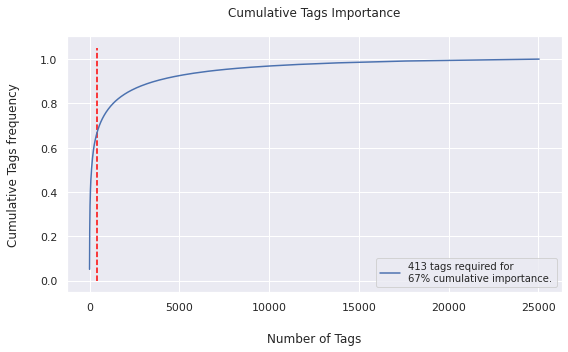

In [26]:
tags_freq_df = get_features_importance(tags_df.index, tags_df.Frequency, verbose=False)
# Threshold = median
tags_threshold = plot_cumulative_features_importance(tags_freq_df,
                                                     threshold=2/3,
                                                     plot_size=(8, 5),
                                                     feature_type='tags',
                                                     return_threshold=True)

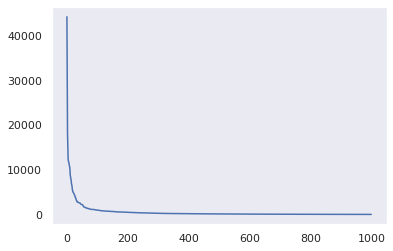

In [27]:
plt.plot(tags_df['Frequency'].iloc[:1000].values)
plt.grid()

### 1.5 - Filter tags  <a class="anchor" id="second_1_5"></a>

In [28]:
# By cumulative frequency
tags_df_filtered = tags_df[:tags_threshold]

In [29]:
tags = tags_df_filtered.index.tolist()
# Get composed tags (e.g : 'react-native' ...)
composed_tags = [tag for tag in tags if '-' in tag]
# Get non-composed tags (e.g : 'python', 'c++' ...)
tags_filtered = [tag for tag in tags if tag not in composed_tags]
print(f'Composed tags : {len(composed_tags)}\nRest : {len(tags_filtered)}')

Composed tags : 119
Rest : 294


In [30]:
# Check if tags contain stopwords
stopwords_tags = [t for t in tags if t in SPACY_DEFAULT_STOPWORDS]
stopwords_tags

['go']

In [31]:
# Filter Tags feature based on n selected tags
# (Optional : use tag list from training dataset, in order to filter tags from validation datasets)
# tags = pickle_data('tags', method='r')
# Filter Tags
df['Tags'] = df.Tags.map(lambda tag_list: [tag for tag in tag_list if tag in tags])
# Filter questions with no tags
rows_ct = df.shape[0]
df = df[df[f'Tags'].map(len) > 0]
get_data_loss(df, rows_ct)

Dataframe rows reduced by 6.0 % (288806 -> 271387)


## 2 - Multivariate analysis <a class="anchor" id="second_2"></a>

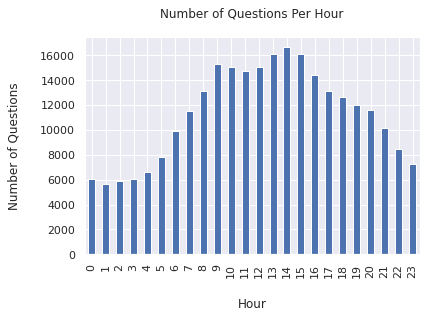

In [32]:
# Total questions per hour
eda = df.copy()
eda['Hour'] = pd.to_datetime(df['CreationDate']).dt.hour
eda.groupby('Hour')['Id'].count().plot(kind='bar')
plt.title('Number of Questions Per Hour', pad=20)
plt.xlabel('Hour', labelpad=20)
plt.ylabel('Number of Questions', labelpad=20)
plt.show()

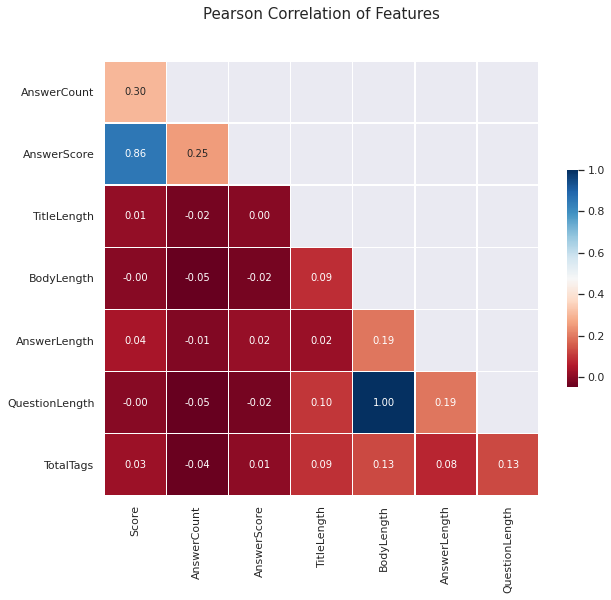

In [33]:
quanti_df = df[numerical_cols+['TotalTags']]
correlation_matrix(quanti_df, as_chart=True, size=(10,8))

## 3 - Factorial analysis (PCA) <a class="anchor" id="second_3"></a>

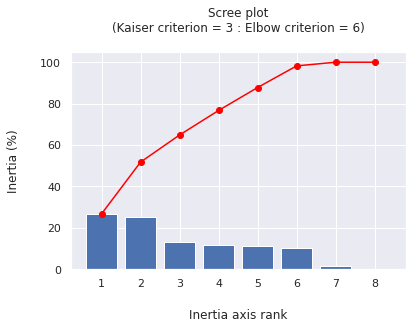

In [34]:
# PCA by first type of property
pca_model = LinearPCA(quanti_df, preprocess_data=False, category_label=None)
pca_model.fit()
pca_model.scree_plot()

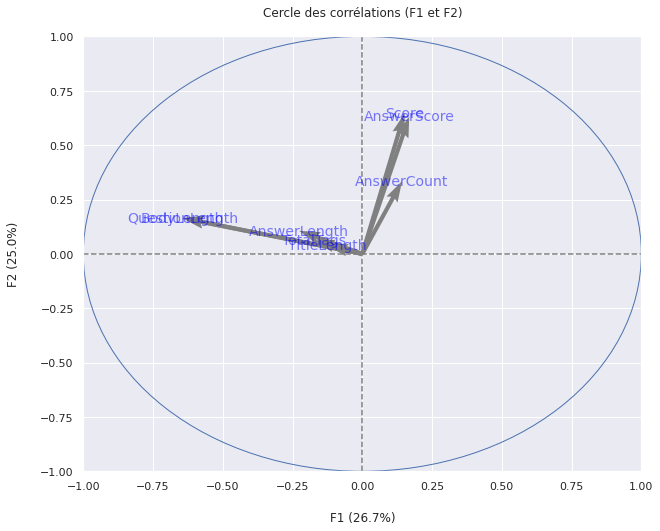

In [35]:
pca_model.plot_correlation_circle(n_plan=1, labels=pca_model.features, save_as_img=False)

# Correlations :
# - ViewCount & Score
# - QuestionLength & BodyLength

# III - Text mining <a class="anchor" id="third"></a>

## 1 - Preprocessing (tokenize & normalize text data) <a class="anchor" id="third_1"></a>

In [36]:
%%time

# Normalize text data (tokenize & filter punctuation characters, numerical values & stopwords)

# Levenshtein similarity parameters
# levenshtein_params = {'threshold': 0.90, 'metric': fuzz.token_set_ratio}

# Lemmatizer parameters
# lemmatizer_params = {'pos_tags_kept': ['NOUN', 'VERB', 'ADV', 'ADJ']}

stopwords_params = {#'other_stopwords': [],
                    'lib': 'spacy',
                    'min_token_length': 2}

# Lowerize programming tags 
tags = [t.lower() for t in tags]

# Text normalizer configuration
text_normalizer_params = {#'lowerizer': True,
                          'no_digits': True,
                          'no_punctuation': True,
                          'no_repeated_characters': True,
                          'no_single_letters': True,
                          'no_stopwords': True,
                          'stopwords_params': stopwords_params,
                          #'no_duplicates': False, 
                          #'no_similar_words': True,
                          #'lemmatizer': True,
                          #'lemmatizer_params': lemmatizer_params,
                          #'levenshtein_params': levenshtein_params,
                          #'duplicates_type': 'token', # only concerns non-domain based tokens
                          'domain_words': tags # keep specific programming tags like 'c++', 'c#' etc ...
                          }

# Tokenize & lowerize question title & body
for text_column in text_columns:
    df[f'{text_column}Tokens'] = df[text_column].map(lambda text: tokenize(text, lowerize=True))

# Get question tokens (merge title & body tokens)
df['QuestionTokens'] = df['TitleTokens'] + df['BodyTokens']

# Get tokens count
# df['TotalTokensCount'] = df['QuestionTokens'].map(len)

# Get tokens unique count
# df['UniqueTokensCount'] = df['QuestionTokens'].map(lambda tokens: len(set(tokens)))

# Normalize question tokens
df['QuestionTokens'] = df['QuestionTokens'].map(lambda text: text_normalizer(text, **text_normalizer_params))

# Filter question with no tokens
df = df[df['QuestionTokens'].map(len) > 0]

CPU times: user 38min 20s, sys: 12.3 s, total: 38min 32s
Wall time: 38min 34s


In [37]:
pd.Series(df['QuestionTokens'].map(len)).describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
QuestionTokens,271387.0,120.840866,143.031346,3.0,51.0,83.0,138.0,3530.0


## 2 - Export modelization dataset <a class="anchor" id="third_2"></a>

In [38]:
# Export EDA main dataset (exhaustive dataset)
df.to_csv('../data/csv/questions_EDA_dataset.csv', index=False)
# Export modelization dataset (minimal dataset)
df_minimal_version = df[['Id', 'QuestionTokens', 'Tags']].copy()
df_minimal_version.to_csv('../data/csv/questions_modelization_dataset.csv', index=False)

## 3 - Areas for improvement <a class="anchor" id="third_3"></a>

In [ ]:
%%time

# Build representative lexicon for each tag combinations (classes)

def build_target_representative_lexicon(df, target, thr=0.25):
    total_questions = df.shape[0]
    tags_lexicon = []
    representative_lexicon = {}
    unique_tag_combs = pd.Series(df[target].map(lambda t: ' '.join(t)).unique()).map(lambda t: t.split())
    tags_count = 0
    for tag in unique_tag_combs:
        # Select all normalized tokens for specific tag class (tag combination)
        df_tokens_tag = df['NormalizedTokens'][df[target].map(lambda t: any(x for x in t if t == tag))]
        # For each normalized tokens get indices and data (list of normalized tokens)
        for idx, tag_tokens in df_tokens_tag.iteritems():
            # Get tokens distribution (BOW)
            tag_tokens_freqdist = nltk.FreqDist(tag_tokens)
            # Get the number of most common selected tag tokens based on threshold value 
            n_most_common_tag_tokens = int(round(thr*len(tag_tokens))) if type(thr) is float else thr
            # Get the n most common selected tag tokens
            if len(tag_tokens)/10 < thr:
                most_freq_tag_tokens_tuples = tag_tokens_freqdist.most_common(n_most_common_tag_tokens)
                most_freq_tag_tokens = list(list(zip(*most_freq_tag_tokens_tuples))[0])
            else:
                most_freq_tag_tokens = tag_tokens
            tag_tokens_lexicon = []
            # For each tag token, add most frequent tag tokens in representative lexicon
            # (N.B : tag tokens must not be in the global lexicon)
            for tag_token in tag_tokens:
                if (tag_token in most_freq_tag_tokens) and (tag_token not in tags_lexicon):
                    tag_tokens_lexicon.append(tag_token)
            # Update translator dictionary (key -> row number, value -> tag tokens representative lexicon)
            if idx not in representative_lexicon.keys():
                representative_lexicon[idx] = tag_tokens_lexicon
            # Add tag tokens representative lexicon to global lexicon
            tags_lexicon.extend(tag_tokens_lexicon)
        # Verbose
        total_questions_ratio = round(len(representative_lexicon.keys()) / total_questions*100, 2)
        total_questions_ratio_str = '{} % of questions'.format(total_questions_ratio)
        tags_count += 1
        tags_ratio_str = '| {} % of tag combinations'.format(round(tags_count / len(unique_tag_combs)*100, 2))
        print(total_questions_ratio_str, tags_ratio_str)
        print('------------------------------------------------------------------')
    df_lexicon = df[df.index.isin(list(representative_lexicon.keys()))].copy()
    representative_lexicon_str = {i: ' '.join(token) for i, token in representative_lexicon.items()}
    df_lexicon['RepresentativeTokens'] = df_lexicon.index.map(representative_lexicon_str).map(lambda t: t.split())
    # Estimate data loss
    old_df_lexicon_rows_ct = df_lexicon.shape[0]
    df_lexicon = df_lexicon[df_lexicon['RepresentativeTokens'].map(len) > 0]
    get_data_loss(df_lexicon, old_df_lexicon_rows_ct)
    return df_lexicon


df_lexicon = build_target_representative_lexicon(df, "Tags", thr=0.25)

# Export tokenized main dataset
# df_lexicon.to_csv('../data/csv/questions_modelization_dataset_lexicon_version.csv', index=False)